In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Run NN model to predict the full price
write a short summery here

In [2]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_05_07.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_20_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_25_06.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", 

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.8285732235716632, 'Train RMSE': 152.9499817085699, 'Train MSE': 23393.696904651868, 'Train MAE': 111.03688606009285, 'Test R2': 0.8303075503629315, 'Test RMSE': 152.77217749860682, 'Test MSE': 23339.338217665827, 'Test MAE': 111.5084146279395, 'Train Size': 29338, 'Test Size': 12574, 'Best Parameters': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}}


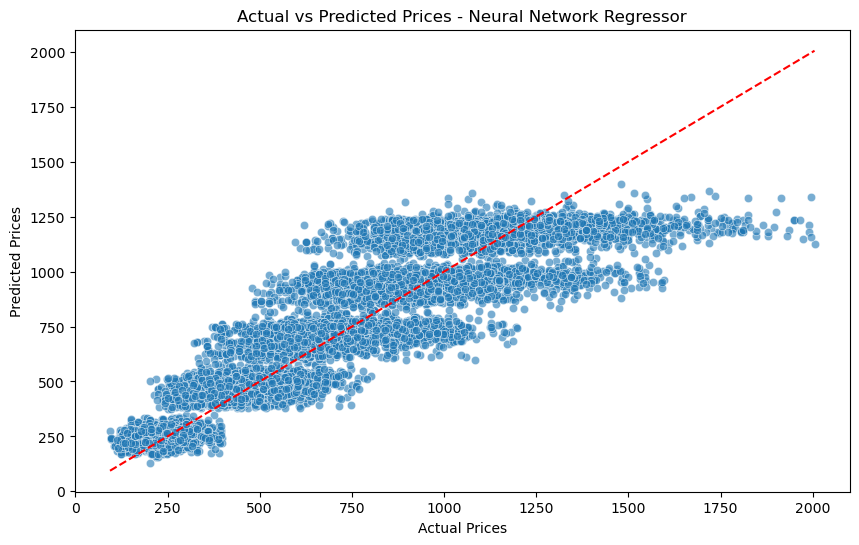

In [3]:
# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
     # Remove columns that are not needed for regression
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

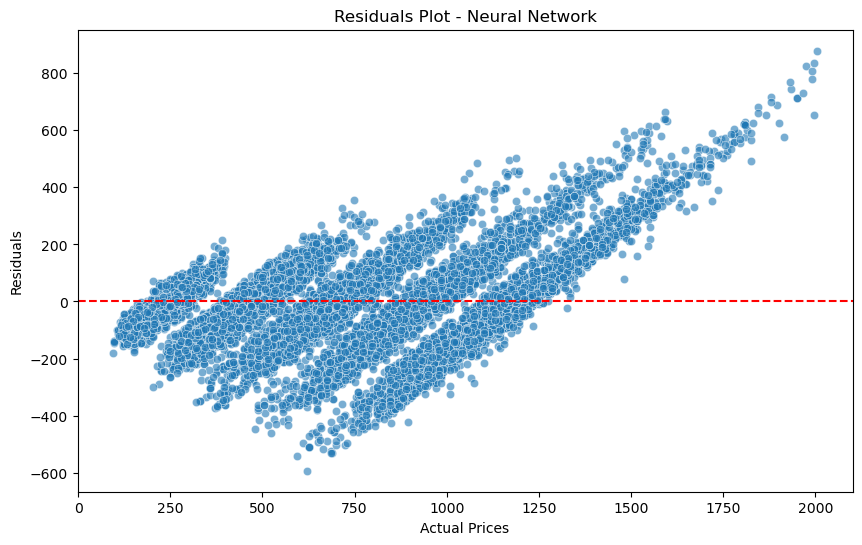

In [4]:
# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network')
plt.show()

# Run neural network model after features engineering to predict the full price

In [5]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_features_engineering_20_06.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_features_engineering_25_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_features_engineering_05_07.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", 

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.8523248216310618, 'Train RMSE': 142.5743510600175, 'Train MSE': 20327.445580185118, 'Train MAE': 102.20620575322386, 'Test R2': 0.849312874401001, 'Test RMSE': 142.51249233199394, 'Test MSE': 20309.810470676635, 'Test MAE': 102.39767938627202, 'Train Size': 29338, 'Test Size': 12574, 'Best Parameters': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}}


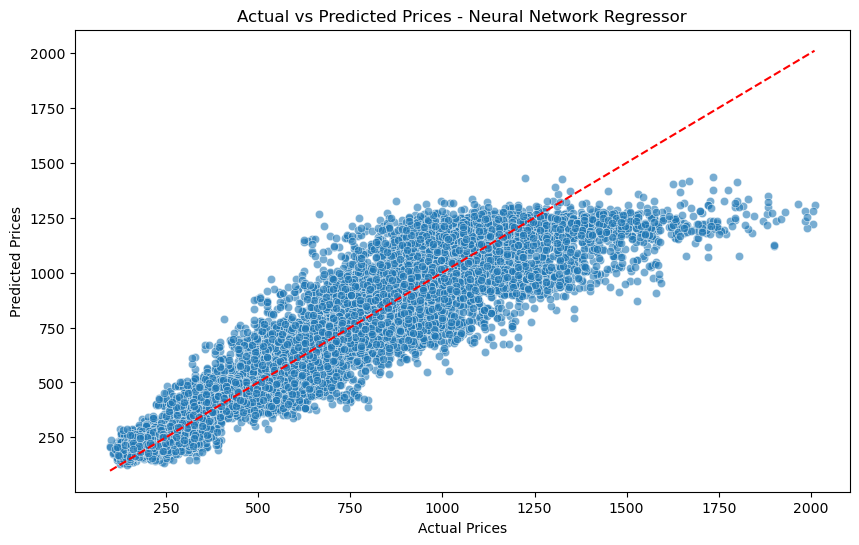

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center',
           'checkin_day', 'checkout_day', 'checkin_day_name_Friday',
           'checkin_day_name_Monday', 'checkin_day_name_Saturday',
           'checkin_day_name_Sunday', 'checkin_day_name_Thursday',
           'checkin_day_name_Tuesday', 'checkin_day_name_Wednesday',
           'checkin_day_name_nan', 'checkout_day_name_Friday',
           'checkout_day_name_Monday', 'checkout_day_name_Saturday',
           'checkout_day_name_Sunday', 'checkout_day_name_Thursday',
           'checkout_day_name_Tuesday', 'checkout_day_name_Wednesday',
           'checkout_day_name_nan', 'period_of_the_month_beginning of the month',
           'period_of_the_month_end of the month',
           'period_of_the_month_middle of the month']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

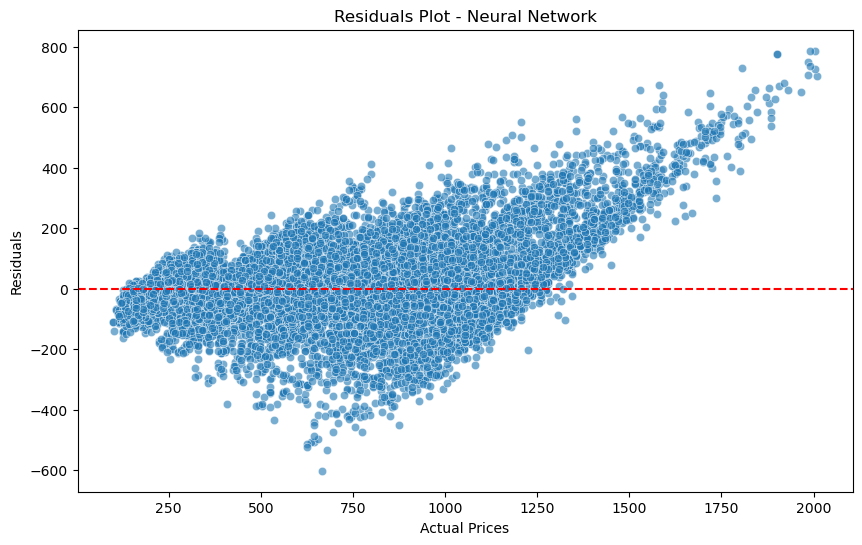

In [7]:
# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network')
plt.show()

# Repeat the process but on data after normalization
1. Linear regression on normalized data
2. Linear regression on normalized data with features engineering

In [ ]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_normalized_data_05_07.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_normalized_data_20_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_normalized_data_25_06.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

In [ ]:
# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
     # Remove columns that are not needed for regression
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

In [ ]:
# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network')
plt.show()

In [ ]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_normalized_with_features_engineering_20_06.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_normalized_with_features_engineering_25_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_normalized_with_features_engineering_05_07.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center',
           'checkin_day', 'checkout_day', 'checkin_day_name_Friday',
           'checkin_day_name_Monday', 'checkin_day_name_Saturday',
           'checkin_day_name_Sunday', 'checkin_day_name_Thursday',
           'checkin_day_name_Tuesday', 'checkin_day_name_Wednesday',
           'checkin_day_name_nan', 'checkout_day_name_Friday',
           'checkout_day_name_Monday', 'checkout_day_name_Saturday',
           'checkout_day_name_Sunday', 'checkout_day_name_Thursday',
           'checkout_day_name_Tuesday', 'checkout_day_name_Wednesday',
           'checkout_day_name_nan', 'period_of_the_month_beginning of the month',
           'period_of_the_month_end of the month',
           'period_of_the_month_middle of the month']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

In [ ]:
# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network')
plt.show()